In [28]:
import pandas as pd
import numpy as np
import regex as re
from nltk.corpus import stopwords
from tqdm import tqdm
import time
import ast
import matplotlib.pyplot as plt
import itertools
from collections import Counter
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from openai import OpenAI
import seaborn as sns
import google.generativeai as genai
import os
from dotenv import load_dotenv

## Prepare Dataset for Analysis

In [29]:
# Read in dataframe
speeches = pd.read_csv("../data/all_speeches.csv")

In [30]:
# Clean DF

# Set dtype and create year column 
speeches['date_original'] = speeches['date']
speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce', infer_datetime_format=True, utc=True)
speeches = speeches.sort_values('date').reset_index(drop=True)
speeches['year'] = speeches['date'].dt.year.astype('Int64')

# Keeping only necessary columns
speeches_clean = speeches[['title', 'date', 'transcript', 'president', 'year']]
# Removing white space
speeches_clean['transcript'] = speeches_clean['transcript'].astype(str).str.strip().dropna()

/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/498610449.py:5: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  speeches['date'] = pd.to_datetime(speeches['date'], errors='coerce', infer_datetime_format=True, utc=True)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/498610449.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_clean['transcript'] = speeches_clean['transcript'].astype(str).str.strip().dropna()


In [31]:
def preprocess_speeches(text):
    """
    Clean and tokenize presidential speeches for embedding training.
    
    Args:
        text: Text to process
    
    """
    
    # Convert to lowercase
    text = text.lower()
    
    # Handle dataset-specific formatting
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'\n+', ' ', text) # Remove newlines
    
    # Basic tokenization (keeping contractions)
    tokens = re.findall(r"\b[a-z]+(?:'[a-z]+)?\b|[a-z]+", text)

    # Remove stopwords, but leave in in/out-group terms
    in_out_group_terms = ['our', 'ours', 'ourselves', 'their', 'theirs', 'them', 'themselves', 'they',  "they'd", 
                        "they'll", "they're", "they've", 'we', "we'd", "we'll", "we're", "we've"]
    stopwords_extracted = stopwords.words('english')
    stopwords_cleaned = [word for word in stopwords_extracted if word not in in_out_group_terms]
    tokens = [t for t in tokens if t not in stopwords_cleaned]
    
    # Filter out very short tokens except in-group terms 
    words_to_keep = ['we', 'us']
    tokens = [t for t in tokens if len(t) > 2 or t in words_to_keep]
    
    return ' '.join(tokens)

# Apply the preprocessing
speeches_clean['transcript_cleaned'] = speeches_clean['transcript'].apply(preprocess_speeches)

/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/2599262696.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speeches_clean['transcript_cleaned'] = speeches_clean['transcript'].apply(preprocess_speeches)


## LLM Analysis

### Adjective Themes

In [32]:
# Access the API key and configure the Gemini model

load_dotenv()

gemini_api_key = os.getenv('GOOGLE_API_KEY')
genai.configure(api_key=gemini_api_key )
model = genai.GenerativeModel('gemini-2.5-flash')

In [33]:
def process_texts_with_llm(texts: list[str], process_function, model, 
                          rate_limit: float = 1.0, cache_results: bool = True):
    """
    Process multiple texts with rate limiting and caching.
    
    Args:
        texts: List of texts to process
        process_function: Function to apply to each text
        model: LLM model to use
        rate_limit: Seconds to wait between API calls
        cache_results: Whether to cache results to avoid reprocessing
    """
    results = []
    cache = {}
    
    for text in tqdm(texts, desc="Processing texts"):
        # Check cache
        text_hash = hash(text)
        if cache_results and text_hash in cache:
            results.append(cache[text_hash])
            continue
        
        # Process with LLM
        try:
            result = process_function(text, model)
            results.append(result)
            
            if cache_results:
                cache[text_hash] = result
                
        except Exception as e:
            print(f"Error processing text: {e}")
            results.append(None)
        
        # Rate limiting
        time.sleep(rate_limit)
    
    return results

In [34]:
def find_adjectives(text: str, model) -> dict[str, any]:
    """
    Use LLM to identify themes in the provided presidential texts

    Args:
        text: Text to process
        model: LLM model to use
    """
    prompt = f"""
    You are using text from presidential speeches to identify the adjectives associated with the core of American identity.
    For each text, output 0-5 of these adjectives. If the speech does not touch on themes of American identity, providing 
    an empty list is acceptable. However, if the speech implies or specifically alludes to themes of American identity, 
    translate these into the adjectives that best represent these themes.

    Do the same for adjectives that best represent the antithesis of American identity as implied or stated in the same text. 
    
    Do not provide an adjective unless it can be justified based on the text. It is acceptable to include fewer than 5 adjectives
    if 5 cannot be justified. 

    Text: {text}

    Response format: JSON format. You must provide an output in JSON format, even if it is just empty lists.

    Here are some examples:

    Text: "Americans will always stand strong in the face of our enemies, who do not have the strength to meet us."
    Possible output:   json(
                        'in_group': ['strong'],
                        'out_group': ['weak']
                       )

    Text: "I want to send a message to all of the god-loving American patriots out there: we see you!"
    Possible output: json(
                        'in_group': ['religious', 'patriotic'],
                        'out_group': []
                       )

    Text: "This new policy will greatly bolster our economy."
    Possible output: json(
                        'in_group': [],
                        'out_group': []
                       )

    """

    response = model.generate_content(contents=prompt)

    output_cleaned = response.text.replace("```json", "").replace("```", "").strip()
    
    return ast.literal_eval(output_cleaned)

In [35]:
# Sample dataset (20% of data)
sample_df = speeches_clean.sample(round(len(speeches_clean)/5))

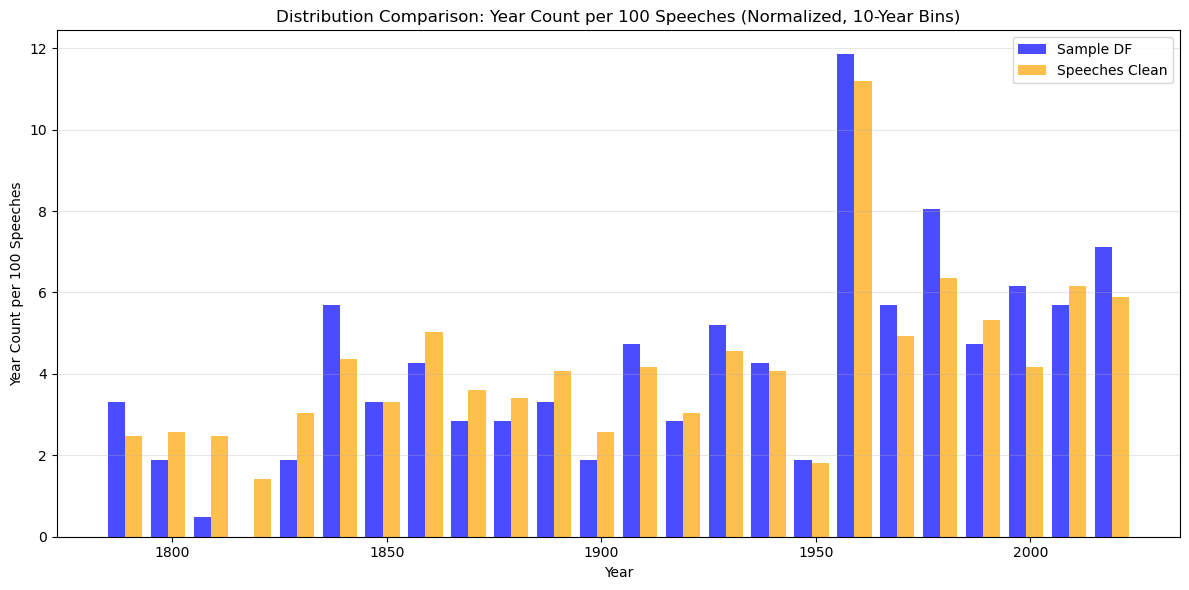

Sample DF: 211 total posts
Speeches Clean: 1,054 total posts


In [36]:
# The distribution of years included in the sample matches the larger dataset decently well

fig, ax = plt.subplots(figsize=(12, 6))

sample_min, sample_max = sample_df['year'].min(), sample_df['year'].max()
speeches_min, speeches_max = speeches_clean['year'].min(), speeches_clean['year'].max()
overall_min = min(sample_min, speeches_min)
overall_max = max(sample_max, speeches_max)

bin_width = 10
bins = np.arange(overall_min, overall_max + bin_width, bin_width)

sample_counts, _ = np.histogram(sample_df['year'], bins=bins)
speeches_counts, _ = np.histogram(speeches_clean['year'], bins=bins)

# Normalize
sample_total = len(sample_df)
speeches_total = len(speeches_clean)
sample_normalized = (sample_counts / sample_total) * 100
speeches_normalized = (speeches_counts / speeches_total) * 100

width = bin_width * 0.4
x = bins[:-1]

ax.bar(x - width/2, sample_normalized, width, label='Sample DF', alpha=0.7, color='blue')
ax.bar(x + width/2, speeches_normalized, width, label='Speeches Clean', alpha=0.7, color='orange')

ax.set_xlabel('Year')
ax.set_ylabel('Year Count per 100 Speeches')
ax.set_title(f'Distribution Comparison: Year Count per 100 Speeches (Normalized, {bin_width}-Year Bins)')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary stats
print(f"Sample DF: {sample_total:,} total posts")
print(f"Speeches Clean: {speeches_total:,} total posts")

In [88]:
# Uncomment to rerun analysis, otherwise upload from saved file

# Running analysis 
# sample_df['adjectives'] = process_texts_with_llm(sample_df.reset_index()['transcript_cleaned'].to_list(), find_adjectives, model)

# # Cleaning results
# sample_df = sample_df[~sample_df['adjectives'].isnull()] # Only drops 4 rows
# sample_df['in_group_adjectives'] = [d.get('in_group') for d in sample_df['adjectives']]
# sample_df['out_group_adjectives'] = [d.get('out_group') for d in sample_df['adjectives']]
# sample_df['out_group_adjectives'] = sample_df['out_group_adjectives'].apply(
#     lambda lst: [s.lower() for s in lst])
# sample_df['in_group_adjectives'] = sample_df['in_group_adjectives'].apply(
#     lambda lst: [s.lower() for s in lst])

# sample_df.to_csv("../data/sample_speeches_llm_enriched.csv", index=False)

# Loading from saved file
sample_df = pd.read_csv("../data/sample_speeches_llm_enriched.csv")
sample_df['in_group_adjectives'] = (sample_df['in_group_adjectives'].apply(ast.literal_eval))
sample_df['out_group_adjectives'] = (sample_df['out_group_adjectives'].apply(ast.literal_eval))
sample_df['race'] = (sample_df['race'].apply(ast.literal_eval))
sample_df['religion'] = (sample_df['religion'].apply(ast.literal_eval))
sample_df['nationality'] = (sample_df['nationality'].apply(ast.literal_eval))
sample_df['immigration_status'] = (sample_df['immigration_status'].apply(ast.literal_eval))
sample_df['political_ideology'] = (sample_df['political_ideology'].apply(ast.literal_eval))

In [89]:
# Getting unique adjectives for both lists

merged_in_group = list(itertools.chain(*sample_df['in_group_adjectives'].to_list()))
in_group_list = set(merged_in_group)
merged_out_group = list(itertools.chain(*sample_df['out_group_adjectives'].to_list()))
out_group_list = set(merged_out_group)

In [90]:
def collapse_adjectives(adj: list, lower_bound: int, upper_bound: int, model: str) -> dict[str, any]:
    """
    Use LLM to identify themes in the provided presidential texts

    Args:
        adj: List of adjectives
        lower_bound: Minimum number of categories
        upper_bound: Maximum number of categories
        model: LLM model to use

    """
    prompt = f"""
    Collapse the following list of adjectives into a smaller number of categories. The number of categories can be 
    between {lower_bound} and {upper_bound}, based on your judgement. Each category should be labeled with an adjective that best summarizes 
    the other adjectives within it based on semantic similarity. Using JSON format, title the entry with the overaching 
    adjective and include the adjectives that fall under this adjective in a list as the value for this key. Include an 
    "other" category for adjectives that cannot be categorized. Only include an output in JSON format, with no additonal
    text.

    {adj}

    """

    response = model.generate_content(contents=prompt)

    output_cleaned = response.text.replace("```json", "").replace("```", "").strip()
    
    return ast.literal_eval(output_cleaned)

In [91]:
# Uncomment to rerun analysis, otherwise upload from saved file below

# in_group_categories_10 = collapse_adjectives(in_group_list, 10, 15, model)
# out_group_categories_10 = collapse_adjectives(out_group_list, 10, 15, model)

# # Find out how "big" the in-group categories are

# # Flatten all lists and count individual words
# all_words = []
# for key_list in sample_df['in_group_adjectives'].to_list():
#     all_words.extend(key_list)
# word_counts = Counter(all_words)

# # Count occurrences per category
# in_group_category_counts = {}
# in_group_category_details = {}

# for category, words in in_group_categories_10.items():
#     total = sum(word_counts.get(word, 0) for word in words)
#     in_group_category_counts[category] = total
    
#     # Store which words from this category appeared
#     category_words_found = {word: word_counts[word] for word in words if word in word_counts}
#     in_group_category_details[category] = category_words_found

# # Results as dictionaries
# in_group_counts = {
#     'total_counts': in_group_category_counts,
#     'word_details': in_group_category_details,
#     'sorted_categories': dict(sorted(in_group_category_counts.items(), key=lambda x: x[1], reverse=True))
# }

# # Access the dictionaries
# print("Total counts per category:")
# in_group_counts['total_counts']

# # Safe to drop 'Frugal' and 'other'

# del in_group_categories_10['Frugal']
# del in_group_categories_10['other']

# Save results
# pd.DataFrame({
#     'adj_theme': list(in_group_categories_10.keys()),
#     'words': list(in_group_categories_10.values())
# }).to_csv('../data/in_group_words_key.csv')

# # Find out how "big" the out-group categories are

# # Flatten all lists and count individual words
# all_words = []
# for key_list in sample_df['out_group_adjectives'].to_list():
#     all_words.extend(key_list)
# word_counts = Counter(all_words)

# # Count occurrences per category
# out_group_category_counts = {}
# out_group_category_details = {}

# for category, words in out_group_categories_10.items():
#     total = sum(word_counts.get(word, 0) for word in words)
#     out_group_category_counts[category] = total
    
#     # Store which words from this category appeared
#     category_words_found = {word: word_counts[word] for word in words if word in word_counts}
#     out_group_category_details[category] = category_words_found

# # Results as dictionaries
# out_group_results = {
#     'total_counts': out_group_category_counts,
#     'word_details': out_group_category_details,
#     'sorted_categories': dict(sorted(out_group_category_counts.items(), key=lambda x: x[1], reverse=True))
# }

# # Access the dictionaries
# print("Total counts per category:")
# out_group_results['total_counts']

# # High number of "Other"... make need further refinement

# out_group_categories_12 = collapse_adjectives(out_group_list, 12, 17, model)

# # Find out how "big" the out-group categories are

# # Flatten all lists and count individual words
# all_words = []
# for key_list in sample_df['out_group_adjectives'].to_list():
#     all_words.extend(key_list)
# word_counts = Counter(all_words)

# # Count occurrences per category
# out_group_category_counts = {}
# out_group_category_details = {}

# for category, words in out_group_categories_12.items():
#     total = sum(word_counts.get(word, 0) for word in words)
#     out_group_category_counts[category] = total
    
#     # Store which words from this category appeared
#     category_words_found = {word: word_counts[word] for word in words if word in word_counts}
#     out_group_category_details[category] = category_words_found

# # Results as dictionaries
# out_group_results = {
#     'total_counts': out_group_category_counts,
#     'word_details': out_group_category_details,
#     'sorted_categories': dict(sorted(out_group_category_counts.items(), key=lambda x: x[1], reverse=True))
# }

# # Access the dictionaries
# print("Total counts per category:")
# out_group_results['total_counts']

# # Safe to drop 'Secretive' and 'Other' 

# del out_group_categories_12['Secretive']
# del out_group_categories_12['Other']

# Save results
# pd.DataFrame({
#     'adj_theme': list(out_group_categories_12.keys()),
#     'words': list(iout_group_categories_12.values())
# }).to_csv('../data/out_group_words_key.csv')

# To get consistent output, upload final versions when not re-running analysis from scratch
in_group_categories_10_df = pd.read_csv('../data/in_group_words_key.csv')
in_group_categories_10_df['words'] = (
    in_group_categories_10_df['words']
    .apply(ast.literal_eval))  # safely parse "['a','b']" → ['a','b']
in_group_categories_10 = dict(zip(in_group_categories_10_df['adj_theme'], in_group_categories_10_df['words']))
in_group_adj_final = list(in_group_categories_10.keys())
out_group_categories_12_df = pd.read_csv('../data/out_group_words_key.csv')
out_group_categories_12_df['words'] = (
    out_group_categories_12_df['words']
    .apply(ast.literal_eval)) 
out_group_categories_12 = dict(zip(out_group_categories_12_df['adj_theme'], out_group_categories_12_df['words']))
out_group_adj_final = list(out_group_categories_12.keys())

### Demographic Groups

In [93]:
def find_demos(text: str, model) -> dict[str, any]:
    """
    Use LLM to identify demographic groups mentioned in the provided presidential texts

    Args:
        text: Text to process
        model: LLM model to use
    """
    prompt = f"""
    In the following presidential speech, identify all of the demographic groups explicitly referred to. Use 1-2
    words to describe each group. Demographic categories exclusively include race, religion, nationality, 
    immigration status, and political ideology.

    Do not provide a demographic group for a category if no group that falls under the category has been explicitly 
    mentioned in this speech.  

    For the nationality category, you should exclude mentions of 'american'.

    Text: {text}

    Response format: JSON format. You must provide an output in JSON format, even if it is just empty lists. Do not 
    provide any accompanying text. Do not output None.

    Here are some examples:

    Text: "We treat our neighbors with respect, whether they are Christian, Jewish, or Muslim."
    Possible output:   json(
                        'race': [],
                        'religion': ['christian', 'jew', 'muslim'],
                        'nationality': [],
                        'immigration_status': [],
                        'political_ideology': []
                       )

    Text: "Illegal aliens are ruining this country for American citizens. Mexicans are bringing crime."
    Possible output: json(
                        'race': [],
                        'religion': [],
                        'nationality': ['mexican'],
                        'immigration_status': ['illegal alien', 'citizen'],
                        'political_ideology': []
                       )

    Text: "This new policy will greatly bolster our economy."
    Possible output: json(
                        'race': [],
                        'religion': [],
                        'nationality': [],
                        'immigration_status': [],
                        'political_ideology': []
                       )

    """

    response = model.generate_content(contents=prompt)

    output_cleaned = response.text.replace("```json", "").replace("```", "").strip()
    
    return ast.literal_eval(output_cleaned)

In [94]:
# Uncomment to rerun analysis, otherwise upload from saved file above 

# # Running analysis
# sample_df['demographic_groups'] = process_texts_with_llm(sample_df.reset_index()['transcript_cleaned'].to_list(), find_demos, model)

# # Cleaning results
# sample_df['race'] = [d.get('race') for d in sample_df['demographic_groups']]
# sample_df['religion'] = [d.get('religion') for d in sample_df['demographic_groups']]
# sample_df['nationality'] = [d.get('nationality') for d in sample_df['demographic_groups']]
# sample_df['immigration_status'] = [d.get('immigration_status') for d in sample_df['demographic_groups']]
# sample_df['political_ideology'] = [d.get('political_ideology') for d in sample_df['demographic_groups']]

# sample_df['race'] = sample_df['race'].apply(
#     lambda lst: [s.lower() for s in lst] if isinstance(lst, list) else [])
# sample_df['religion'] = sample_df['religion'].apply(
#     lambda lst: [s.lower() for s in lst] if isinstance(lst, list) else [])
# sample_df['nationality'] = sample_df['nationality'].apply(
#     lambda lst: [s.lower() for s in lst] if isinstance(lst, list) else [])
# sample_df['immigration_status'] = sample_df['immigration_status'].apply(
#     lambda lst: [s.lower() for s in lst] if isinstance(lst, list) else [])
# sample_df['political_ideology'] = sample_df['political_ideology'].apply(
#     lambda lst: [s.lower() for s in lst] if isinstance(lst, list) else [])

# sample_df.to_csv("../data/sample_speeches_llm_enriched.csv", index=False)

In [95]:
# Cutting out duplicates

merged_race = list(itertools.chain(*sample_df['race'].to_list()))
race_list = set(merged_race)
merged_religion = list(itertools.chain(*sample_df['religion'].to_list()))
religion_list = set(merged_religion)
merged_nationality = list(itertools.chain(*sample_df['nationality'].to_list()))
nationality_list = set(merged_nationality)
merged_immigration_status = list(itertools.chain(*sample_df['immigration_status'].to_list()))   
immigration_status_list = set(merged_immigration_status)   
merged_political_ideology = list(itertools.chain(*sample_df['political_ideology'].to_list()))
political_ideology_list = set(merged_political_ideology)     

In [96]:
def collect_sentences_with_substring(main_string, substrings):
    """
    Collects sentences from a string that contain a specific substring 
    as a whole word, **ignoring case**.

    Args:
        main_string (str): The main string to search within.
        substrings (list of str): List of substrings to search for.
    """
    # Split the string into sentences
    sentences = re.split(r'(?<=[.!?])\s+', main_string)
    
    # Construct the regular expression for whole word matching
    
    # Escape each word and join them with the OR operator 
    escaped_words = [re.escape(word) for word in substrings]
    or_pattern = '|'.join(escaped_words)
    
    # Construct the final pattern with word boundaries
    word_pattern = r'\b(' + or_pattern + r')\b'
    
    # Filter the sentences
    matching_sentences = [
        sentence 
        for sentence in sentences 
        if re.search(word_pattern, sentence, re.IGNORECASE)
    ]
    
    return matching_sentences

In [97]:
def find_word_meaning_in_context(text: str, word_list: list[str], definition: str, model: str, api_key: str) -> int:
    """
    Use LLM to identify the in-context meaning of ambiguous words

    Args:
        text: Text to process
        word_list: List of words to check
        definition: Definition to check against
        model: LLM model to use
        api_key: API key for the LLM service
    """
    prompt = f"""
    Use the following text to determine whether instances of the words {','.join(word_list)} meet this definition at any point 
    in the text: {definition}.

    Text: {text}

    Response format: 1 if the answer is yes, and 0 if the answer is no. Please output an int.

    Here are some examples:

    Text: "This is the right thing to do."
    Word: "right"
    Definition: "political ideology"
    Possible output: 0

    Text: "Right wing extremism has become a major issue in this country."
    Word: "right"
    Definition: "political ideology"
    Possible output: 1

    Text: "Right wing extremism has become a major issue in this country. This right thing to do is fight back."
    Word: "right"
    Definition: "political ideology"
    Possible output: 1

    """
    # intialize Client
    client = OpenAI(
    base_url="https://openrouter.ai/api/v1", 
    api_key=api_key,
    )

    system_content = "You are tasked with identifying the in-context meaning of ambiguous words."

    messages = [
    {"role": "system", "content": system_content},
    {"role": "user", "content": prompt}
    ]

    response = client.chat.completions.create(
    model=model,
    messages=messages
    )

    response = response.choices[0].message.content
    
    return response

In [98]:
def process_texts_with_llm_2(texts: list[str], process_function, word_list: list[str], definition: str, model: str, 
                             api_key: str, rate_limit: float = 1.0, cache_results: bool = True):
    """
    Process multiple texts with rate limiting and caching, forwarding 
    required constant arguments to the processing function.
    
    Args:
        texts: List of texts to process (e.g., collapsed sentences).
        process_function: Function to apply to each text (e.g., find_word_meaning_in_context).
        word (str): The constant word argument needed by process_function.
        definition (str): The constant definition argument needed by process_function.
        model: LLM model to use.
        rate_limit: Seconds to wait between API calls.
        cache_results: Whether to cache results to avoid reprocessing.
    """
    results = []
    cache = {}
    
    # Use the appropriate arguments for the hash key, which should only be the text content
    # (Since word/definition/model are constants for this entire batch)
    
    for text in tqdm(texts, desc="Processing texts"):
        
        # Check cache
        # Using the text itself as the cache key is generally safer than hash()
        if cache_results and text in cache:
            results.append(cache[text])
            continue
        
        # Process with LLM, pass the 'word' and 'definition' arguments
        try:
            result = process_function(text, word_list, definition, model, api_key)
            results.append(result)
            
            if cache_results:
                cache[text] = result
                
        except Exception as e:
            # It's helpful to see the text that caused the error
            print(f"Error processing text (Text start: '{text[:50]}...'): {e}")
            results.append(None)
        
        # 3. Rate limiting
        time.sleep(rate_limit)
    
    return results

In [99]:
def apply_find_word_meaning_in_context(df: pd.DataFrame, word_list: list[str], definition: str, model: str, api_key: str) -> pd.DataFrame:
    """
    Apply the function to a DataFrame to find word meanings in context.

    Args:
        df: DataFrame containing speeches
        word_list: List of words to check
        definition: Definition to check against
        model: LLM model to use
        api_key: API key for the LLM service
    """

    api_key = os.getenv('OPEN_ROUTER_KEY')

    collapsed_words = ','.join(word_list)

    # Finding sentences containing word
    df[f'{collapsed_words}_mentions'] = df['transcript'].apply(collect_sentences_with_substring, substrings=word_list)
    df[f'{collapsed_words}_mentions_collapsed'] = df[f'{collapsed_words}_mentions'].apply(lambda x: ' '.join(x))
    # Limiting to rows that have mention of the word
    with_word_df = df[df[f'{collapsed_words}_mentions_collapsed'].str.len() != 0]

    # Find out if the use of the words meets the definition at least once
    with_word_df[f'{collapsed_words}_as_{'_'.join(definition.split())}'] = process_texts_with_llm_2(
        with_word_df[f'{collapsed_words}_mentions_collapsed'].to_list(), 
        find_word_meaning_in_context, 
        collapsed_words, 
        definition, 
        model, 
        api_key,
        rate_limit=1
        )

    # Merging results with original df
    final_df = pd.merge(
        df, 
        with_word_df[[f'{collapsed_words}_as_{'_'.join(definition.split())}']], 
        left_index=True, 
        right_index=True, 
        how='left')

    return final_df

In [100]:
# Issues using gemini so switching to new model

open_router_api_key = os.getenv('OPEN_ROUTER_KEY')
model = 'openai/gpt-5.1-codex-mini'

In [101]:
# Uncomment to rerun analysis, otherwise upload from saved file

# # Determining whether mentions of white, black, colored, minority, minorities are refering to racial categories

# speeches_clean_meaning_w_context = apply_find_word_meaning_in_context(speeches_clean, ['white','black','colored','minorities','minorities'], 'racial category', model, open_router_api_key)
# speeches_clean_meaning_w_context.to_csv("../data/speeches_w_demographic_categories_llm_enriched.csv", index=False)

# Uploading from saved file
speeches_clean_meaning_w_context = pd.read_csv("../data/speeches_w_demographic_categories_llm_enriched.csv")

In [102]:
# Worth differentiating
speeches_clean_meaning_w_context['white,black,colored,minorities,minorities_as_racial_category'].value_counts()

white,black,colored,minorities,minorities_as_racial_category
0.0    210
1.0    181
Name: count, dtype: int64

In [103]:
# Uncomment to rerun analysis, otherwise upload from saved file above

# # Determining whether mentions of indian, indians refer to people from south asia or the natives americans

# speeches_clean_meaning_w_context = apply_find_word_meaning_in_context(speeches_clean_meaning_w_context, ['indian','indians'], 'native americans', model, open_router_api_key)
# speeches_clean_meaning_w_context.to_csv("../data/speeches_w_demographic_categories_llm_enriched.csv", index=False)

In [104]:
# Safe to ignore mentions of south asian indians
speeches_clean_meaning_w_context['indian,indians_as_native_americans'].value_counts()

indian,indians_as_native_americans
1.0    178
0.0     19
Name: count, dtype: int64

In [105]:
# Uncomment to rerun analysis, otherwise upload from saved file above

# # Determining whether mentions of right, left are refering to political ideologies

# speeches_clean_meaning_w_context = apply_find_word_meaning_in_context(speeches_clean_meaning_w_context, ['right','left'], 'political ideology', model, open_router_api_key)
# speeches_clean_meaning_w_context.to_csv("../data/speeches_w_demographic_categories_llm_enriched.csv", index=False)

In [106]:
# Safe to remove these words... they are almost never used to refer to ideologies
speeches_clean_meaning_w_context['right,left_as_political_ideology'].value_counts()

right,left_as_political_ideology
0.0    749
1.0     34
Name: count, dtype: int64

In [107]:
# Uncomment to rerun analysis, otherwise upload from saved file above

# # Determining whether mentions of democratic, independent, liberal, conservative are refering to people with the corresponding political view

# speeches_clean_meaning_w_context = apply_find_word_meaning_in_context(speeches_clean_meaning_w_context, ['democratic', 'independent', 'liberal', 'conservative'], 'people with corresponding political view', model, open_router_api_key)
# speeches_clean_meaning_w_context.to_csv("../data/speeches_w_demographic_categories_llm_enriched.csv", index=False)

In [108]:
# Worth differentiating
speeches_clean_meaning_w_context['democratic,independent,liberal,conservative_as_people_with_corresponding_political_view'].value_counts()

democratic,independent,liberal,conservative_as_people_with_corresponding_political_view
0.0    401
1.0    140
Name: count, dtype: int64

In [109]:
# Uncomment when reruning analysis to save final results

# # Saving results
# speeches_clean_meaning_w_context = pd.read_csv("../data/speeches_w_demographic_categories_llm_enriched.csv")

In [110]:
def add_tag(df: pd.DataFrame, col_name: str, dummy: int, tag: str) -> pd.DataFrame:
    
    """
    Add a tag to words in the transcript based on the meaning indicated by the dummy variable.
    
    Args:
        df: DataFrame containing speeches
        col_name: Column name with dummy variable
        dummy: Dummy variable indicating meaning
        tag: Tag to add to words in transcript
   """

    # Set dtype
    df[col_name] = df[col_name].astype(int, errors = 'ignore')

    # Create a regex pattern that matches whole words only
    words = col_name.split('_')[0]
    pattern = r'\b(' + '|'.join(words.split(',')) + r')\b'

    # Apply the replacement efficiently
    df.loc[
        df[col_name] == dummy,
        'transcript_cleaned'

    ] = df.loc[
        df[col_name] == dummy,
        'transcript_cleaned'
    ].str.replace(pattern, rf'\1 ({tag})', regex=True, case=False)

    return df

# Uncomment to rerun analysis, otherwise upload from saved file above

# # Tagging words based on their meaning to created distinct terms for them

# speeches_clean_meaning_w_context = add_tag(speeches_clean_meaning_w_context, 
#         'white,black,colored,minorities,minorities_as_racial_category', 
#         1,
#         'race'
#         )

# speeches_clean_meaning_w_context = add_tag(speeches_clean_meaning_w_context, 
#         'indian,indians_as_native_americans', 
#         1,
#         'native american'
#         )

# speeches_clean_meaning_w_context = add_tag(speeches_clean_meaning_w_context, 
#         'indian,indians_as_native_americans', 
#         0,
#         'south asian'
#         )

# speeches_clean_meaning_w_context = add_tag(speeches_clean_meaning_w_context, 
#         'democratic,independent,liberal,conservative_as_people_with_corresponding_political_view', 
#         1,
#         'person'
#         )

# # Saving results
# speeches_clean_meaning_w_context.to_csv("../data/speeches_w_demographic_categories_llm_enriched.csv", index=False)

In [129]:
# Manual cleaning of demographic lists

race_words_to_remove = [
    'african blood', 'african', 'alien race', 'african descent', 'color', 'emancipated', 'german ancestry', 
    'chinese', 'filipino', 'chinese laborer', 'chinese coolie', 'educated chinese', 'mixed blood', 'coolie',
    'predatory savages', 'savages', 'chinaman', 'freedmen', 'colors', 'race', 'races', 'racial', 'tribe',

    'white', 'black', 'colored', 'minority', 'minorities', 'indian', 'indians' # Replacing with tagged words
    ]

# Switching from race to nationality category
race_to_nationality = [
    'kickapoo', 'metlakahtla indian', 'seminole', 'creek', 'tonkawa', 'cherokee', 'chickasaw', 'hutus', 
    'five civilized', 'shawanese', 'kurds', 'sioux', 'muscogee creek', 'nez perce', 'choctaw', 'wichita', 
    'cherokees', 'mosquito indian', 'tutsis', 'piankeshaw', 'six nations'
]

race_tagged_words = ['white (race)', 'black (race)', 'colored (race)', 'minority (race)', 'minorities (race)', 
                     'indian (native american)', 'indians (native american)']

race_list_cleaned = [word for word in race_list if word not in race_words_to_remove]
race_list_cleaned = [word for word in race_list_cleaned if word not in race_to_nationality]
race_list_cleaned = [word.replace('people color', 'people of color') for word in race_list_cleaned]
race_list_cleaned = sorted(race_list_cleaned + race_tagged_words)

religion_words_to_remove = [
    'ame', 'conformist', 'faith leaders', 'creed', 'creed', 'faiths', 'god-fearing', 'godless',
    'high churchman', 'judeo-christian', 'pilgrim', 'religious', 'religious congregations', 'religious leader',
    'schismatic', 'race', 'races', 'racial', 'predatory savages', 'savages', 'tribe', 'creeds'
    ]

religion_list_cleaned = [word for word in religion_list if word not in religion_words_to_remove]

nationality_words_to_remove = [
    'afghanistan', 'alien', 'asia', 'asian', 'athens', 'australia', 'austria', 'barbary', 'belgium', 'brazil',
    'britain', 'british subject', 'buenos aires', 'cambodia', 'canada', 'cherokee', 'china', 'colonist',
    'denmark', 'dictatorship', 'ecuadorean', 'egypt', 'estonia', 'europe', 'finland', 'foreign power',
    'france', 'gaul', 'great britain', 'guatemala', 'gulf state', 'haytian', 'holland', 'hungary', 
    'indochinese', 'iran', 'italy', 'japan', 'kongo', 'latin', 'latvia', 'lithuania', 'magyar', 'south vietnam',
    'malagasy', 'mexico', 'mosquito', 'native', 'nebraska', 'neutral nations', 'north korea', 'roumanian',
    'panama', 'persia', 'poland', 'red chinese', 'rome', 'russia', 'salvador', 'santo domingo',
    'saudi arabia', 'scandinavia', 'scythia', 'servian', 'somalia', 'spain', 'uganda', 'ukraine',
    'ulster scots', 'vietcong', 'west india', 'tripoli', 'arab', 'soviet', 'germany', 'muscati',
    'hanseatic', 'helvetic', 'tunis', 'foreigner', 'foreign', 'foreigners', 'south asia', 'western europe',

    'indian', 'indians' # Replace with tagged words
    ]

nationality_tagged_words = ['indian (south asian)', 'indians (south asian)']

nationality_list_cleaned = [word for word in nationality_list if word not in nationality_words_to_remove]
nationality_list_cleaned = sorted(nationality_list_cleaned + race_to_nationality + nationality_tagged_words)

immigration_status_words_to_remove = [
    'apprentice', 'british subject', 'children', 'colonist', 'criminal', 'chinese coolie', 'chinese laborer', 
    'criminal', 'criminal alien', 'criminal aliens', 'criminals', 'daca', 'daughters', 'domiciled alien', 
    'enemy combatants', 'foreign birth', 'foreign convict', 'foreign residents', 'foreign-born', 'fugitives',
    'gang members', 'laborer', 'laborers', 'mothers', 'native-born', 'new citizen', 'newcomer', 'nonresidents',
    'people illegally', 'settler', 'slave', 'slaves', 'spanish subject', 'stranger', 'subject', 'subjects',
    'undesirable', 'tps', 'women', 'pauper', 'pilgrim', 'national'
]

immigration_status_list_cleaned = sorted([word for word in immigration_status_list if word not in immigration_status_words_to_remove])

political_ideology_words_to_remove = [
    'absolutist', 'anti-improvements', 'appeaser', 'aristocracy', 'anti-silver', 'armed minority', 'axis evil', 'communism',
    'balmaceda adherents', 'barnburner', 'bigot', 'bimetallist', 'congressional party', 'constitutional friends', 'revolutionary',
    'copperhead', 'cuban-backed guerrillas', 'cynic', 'cynics', 'demagogue', 'designing men', 'dictator', 'dictators',
    'different views', 'disciples liberty', 'dominant senators', 'enemies freedom', 'enemies order', 'extremism',
    'faction', 'fanatic', 'farmer labor', 'fascism', 'fifth columnist', 'free', 'free men', 'free people', 'free peoples',
    'free silver', 'free soiler', 'free world', 'freedom advocates', 'freedom enemies', 'freedom-loving', 'freeman', 'political partisan', 
    'friends government', 'friends of liberty', 'government upholders', 'intriguers', 'just forces', 'liberty partisan',
    'loyal', 'majority', 'militant', 'military cliques', 'military junta', 'minority', 'minority party', 'monometallist',
    'nra household', 'opposite party', 'outlaw regime', 'parties', 'party', 'party affiliation', 'party members', 'party voters',
    'patriot', 'patriots',  'patriotic', 'peace loving', 'peace men', 'totalitarian', 'perot voter', 'political parties', 
    'political party', 'terrorist', 'prevailing party', 'pro-improvements', 'qaeda', 'radical', 'radicals', 'rebel', 'rebellion participants', 
    'rebels', 'right-wing dictators', 'savage forces', 'sectional', 'self governing', 'soft hunker', 'tariff opponents', 'traitors', 
    'tyranny', 'well disposed', 'world conquerors', 'america first', 'democracy', 'insurgent', 'insurgents', 'left', 'right',
    
    'democratic', 'liberal', 'conservative', 'independent' # Replace with tagged words
]

political_ideology_tagged_words = ['democratic (person)', 'liberal (person)', 'conservative (person)', 'independent (person)']

political_ideology_list_cleaned = [word for word in political_ideology_list if word not in political_ideology_words_to_remove]
# replacing left and right with left-wing and right-wing since right/ left alone have so many meanings
# also replacing fascism with fascist since this is a person-focused analysis
political_ideology_list_cleaned = sorted(political_ideology_list_cleaned + ['left wing', 'right wing', 'fascist'] + political_ideology_tagged_words)

In [130]:
demographic_groups = {
    'race': race_list_cleaned,
    'religion': religion_list_cleaned,
    'nationality': nationality_list_cleaned,
    'immigration_status': immigration_status_list_cleaned,
    'political_ideology': political_ideology_list_cleaned
}

In [131]:
def count_term_frequency(df, text_col, demographic_groups):
    """
    Counts how often each demographic group term appears in the corpus.
    Returns a dataframe with term, category, and count.

    Args:
        df: DataFrame containing speeches
        text_col: Column name with speech text
        demographic_groups: Dictionary of demographic groups and their terms
    """
    results = []
    # Join all speeches into one giant text block
    full_text = " ".join(df[text_col].astype(str).tolist()).lower()
    
    for category, group_list in demographic_groups.items():
        for term in group_list:

            # For terms with parentheses or special chars, escape but keep pattern functional
            # Use re.escape but build the word boundary pattern correctly
            escaped = re.escape(term.lower())
            
            # Don't add \b if the term starts/ends with non-word characters like '('
            # Instead, use a more flexible approach
            if re.match(r'\w', term[0]) and re.match(r'\w', term[-1]):
                # Term starts and ends with word characters
                pattern = r'\b' + escaped + r'\b'
            else:
                # Term has special characters at boundaries
                pattern = escaped
            
            count = len(re.findall(pattern, full_text))
            
            results.append({
                'category': category,
                'term': term,
                'count': count
            })
    
    return pd.DataFrame(results)

freq_df = count_term_frequency(speeches_clean_meaning_w_context, 'transcript_cleaned', demographic_groups)


In [132]:
# Extract terms that have over 20 appearances 
top_terms = set(freq_df[freq_df['count'] > 20]['term'].tolist())

# Build filtered dict
filtered_demographic_groups = {}

for category, term_list in demographic_groups.items():
    filtered = [t for t in term_list if t in top_terms]
    if filtered:
        filtered_demographic_groups[category] = filtered

## Word Embeddings Analysis

In [118]:
# Load model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Use sentences containing the adjectives
def get_contextual_embedding(df, words_list, text_column='transcript_cleaned'):
    """
    Extract actual sentences containing these words from the corpus.

    Args:
        df: DataFrame containing speeches
        words_list: List of words to find in the corpus
        text_column: Column name with speech text
    """
    sentences = []
    
    for word in words_list:
        mask = df[text_column].str.contains(word, case=False, na=False)
        matching_texts = df[mask][text_column].tolist()
        
        # Extract sentences containing the word
        for text in matching_texts[:50]: # Limit per word
            if pd.notna(text):
                # Split into sentences (simple approach)
                text_sentences = text.split('.')
                for sent in text_sentences:
                    if word.lower() in sent.lower():
                        sentences.append(sent.strip())
    
    if not sentences:
        return model.encode(" ".join(words_list))
    
    # Get embeddings for sentences
    embeddings = model.encode(sentences)
    return np.mean(embeddings, axis=0)

# Flatten the category dictionaries to get all adjectives
in_group_adjectives_all = []
for category, adj_list in in_group_categories_10.items():
    in_group_adjectives_all.extend(adj_list)

out_group_adjectives_all = []
for category, adj_list in out_group_categories_12.items():
    out_group_adjectives_all.extend(adj_list)

print(f"In-group adjectives: {len(in_group_adjectives_all)} words")
print(f"Out-group adjectives: {len(out_group_adjectives_all)} words")

# Get corpus-grounded embeddings using all adjectives
print("Creating corpus-grounded embeddings...")
american_emb = get_contextual_embedding(speeches_clean_meaning_w_context, in_group_adjectives_all, 'transcript_cleaned')
non_american_emb = get_contextual_embedding(speeches_clean_meaning_w_context, out_group_adjectives_all, 'transcript_cleaned')

In-group adjectives: 193 words
Out-group adjectives: 285 words
Creating corpus-grounded embeddings...


In [137]:
# Looping through each demographic group
results_dict = {}
for category, groups in filtered_demographic_groups.items():
    print(f"Processing {category}...")
    results_dict[category] = []
    for group in groups:
        # Get embedding for demographic group from corpus context
        group_emb = get_contextual_embedding(speeches_clean_meaning_w_context, [group], 'transcript_cleaned')
        
        american_sim = cosine_similarity([group_emb], [american_emb])[0][0]
        non_american_sim = cosine_similarity([group_emb], [non_american_emb])[0][0]
        
        results_dict[category].append({
            'group': group,
            'american_similarity': american_sim,
            'non_american_similarity': non_american_sim,
            'difference': american_sim - non_american_sim
        })

Processing race...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h

Processing religion...
Processing nationality...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)


Processing immigration_status...
Processing political_ideology...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h

In [138]:
# Statistical summary
all_results = []
for category, data in results_dict.items():
    for item in data:
        all_results.append({
            'category': category,
            'group': item['group'],
            'american_sim': item['american_similarity'],
            'non_american_sim': item['non_american_similarity'],
            'difference': item['difference']
        })

results_df = pd.DataFrame(all_results)
# Save
results_df.to_csv("../data/demographic_group_american_nonamerican_similarity_results.csv", index=False)

print("\n=== Most 'American' Associated Groups (in Presidential Speeches) ===")
print(results_df.nlargest(15, 'difference')[['category', 'group', 'difference']])

print("\n=== Most 'Non-American' Associated Groups (in Presidential Speeches) ===")
print(results_df.nsmallest(15, 'difference')[['category', 'group', 'difference']])

print("\n=== Average Difference by Category ===")
print(results_df.groupby('category')['difference'].median().sort_values(ascending=False))


=== Most 'American' Associated Groups (in Presidential Speeches) ===
               category                      group  difference
12                 race                     native    0.016188
13                 race            native american    0.015622
86   immigration_status                    citizen    0.015392
87   immigration_status                   citizens    0.015392
9                  race   indian (native american)    0.014305
31          nationality                    british    0.013631
108  political_ideology       independent (person)    0.013306
10                 race  indians (native american)    0.012305
51          nationality       indian (south asian)    0.011054
46          nationality                     french    0.010398
96   immigration_status                   resident    0.009443
35          nationality                   cherokee    0.008601
36          nationality                  cherokees    0.008270
7                  race             colored (rac

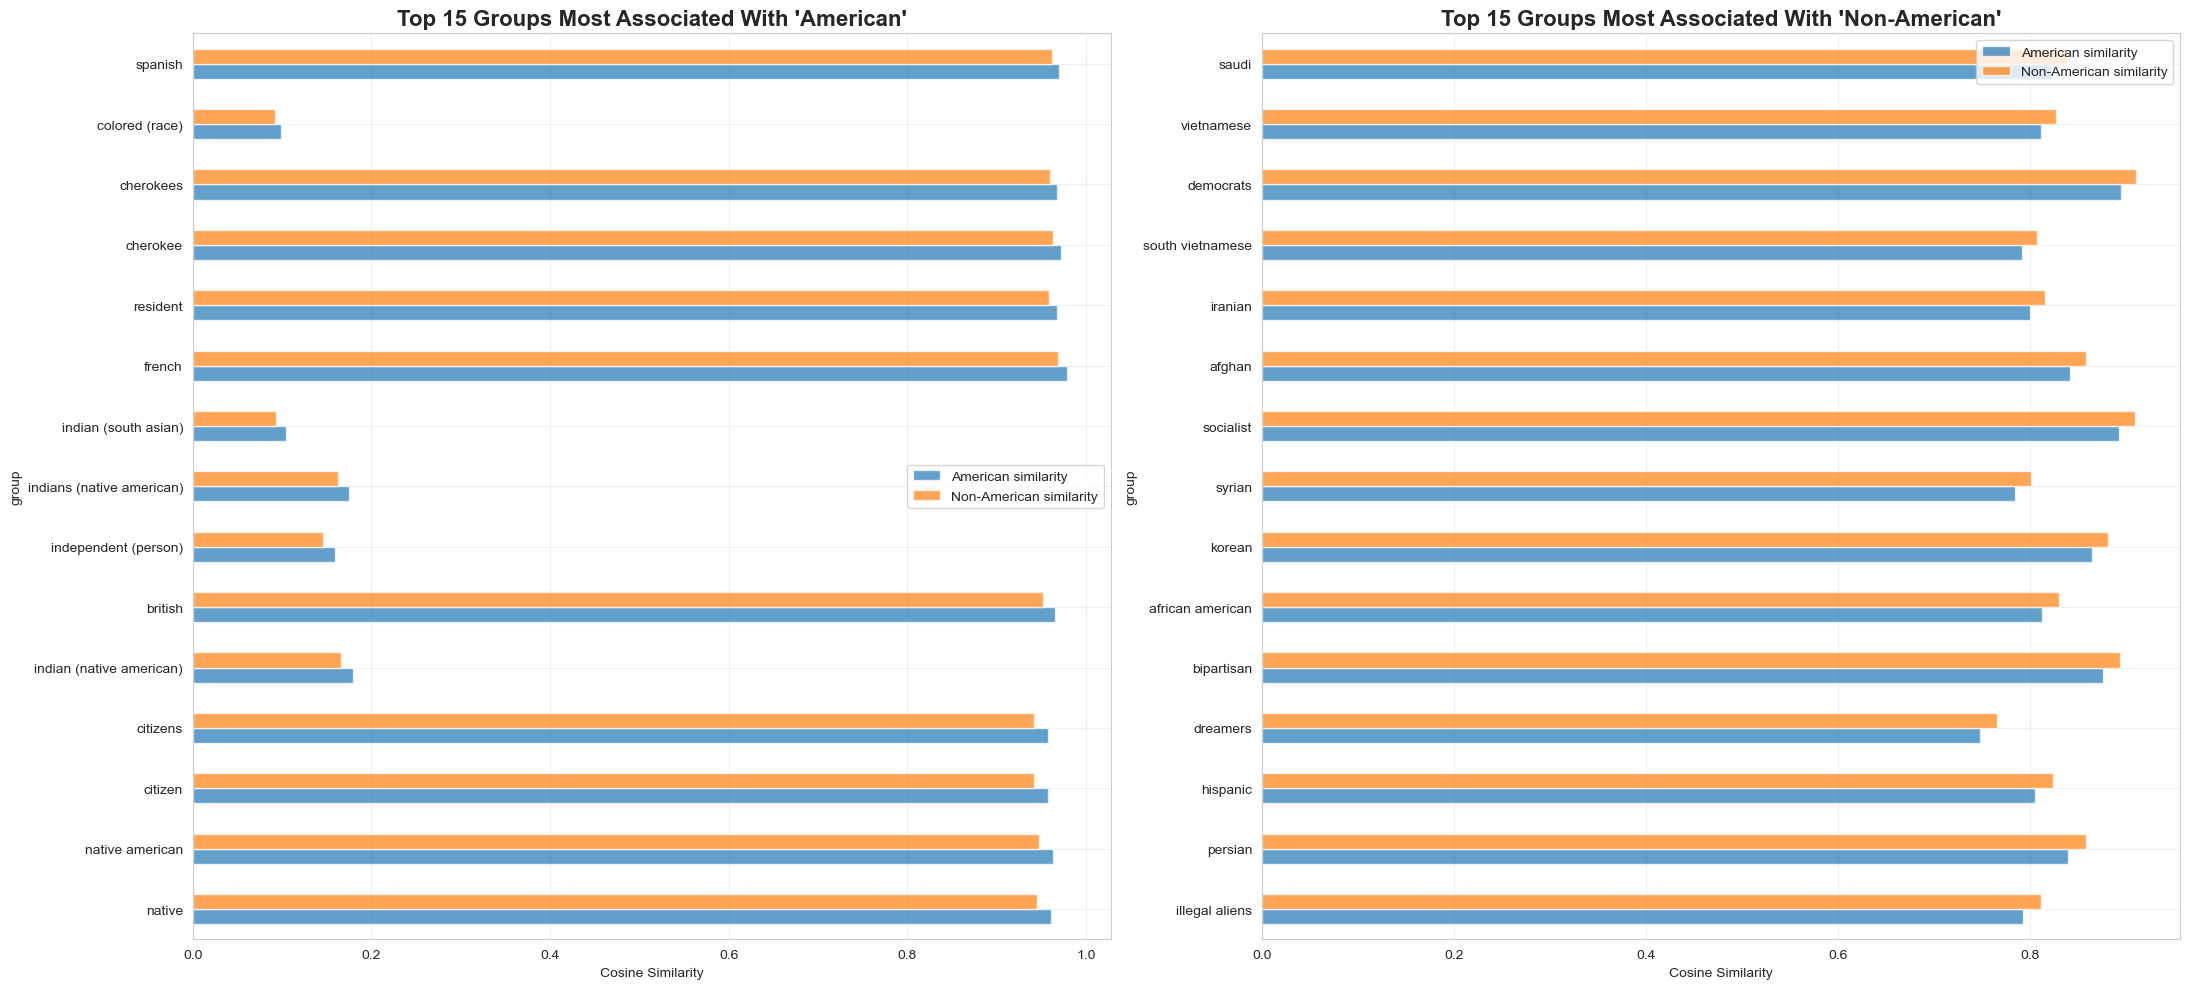

In [139]:
# Set style
sns.set_style("whitegrid")

# Create results_df
all_results = []
for category, data in results_dict.items():
    for item in data:
        all_results.append({
            'category': category,
            'group': item['group'],
            'american_similarity': item['american_similarity'],
            'non_american_similarity': item['non_american_similarity'],
            'difference': item['difference']
        })

results_df = pd.DataFrame(all_results)

# Select top and bottom 15
top15 = results_df.nlargest(15, 'difference')
bottom15 = results_df.nsmallest(15, 'difference')

# Side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

# Most American-associated 
top_df = top15.set_index('group')
top_df[['american_similarity', 'non_american_similarity']].plot(
    kind='barh', ax=axes[0], alpha=0.7
)

axes[0].set_title("Top 15 Groups Most Associated With 'American'",
                  fontsize=16, fontweight='bold')
axes[0].set_xlabel("Cosine Similarity")
axes[0].legend(['American similarity', 'Non-American similarity'])
axes[0].grid(True, alpha=0.3)

# Most Non-American-associated 
bottom_df = bottom15.set_index('group')
bottom_df[['american_similarity', 'non_american_similarity']].plot(
    kind='barh', ax=axes[1], alpha=0.7
)

axes[1].set_title("Top 15 Groups Most Associated With 'Non-American'",
                  fontsize=16, fontweight='bold')
axes[1].set_xlabel("Cosine Similarity")
axes[1].legend(['American similarity', 'Non-American similarity'])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

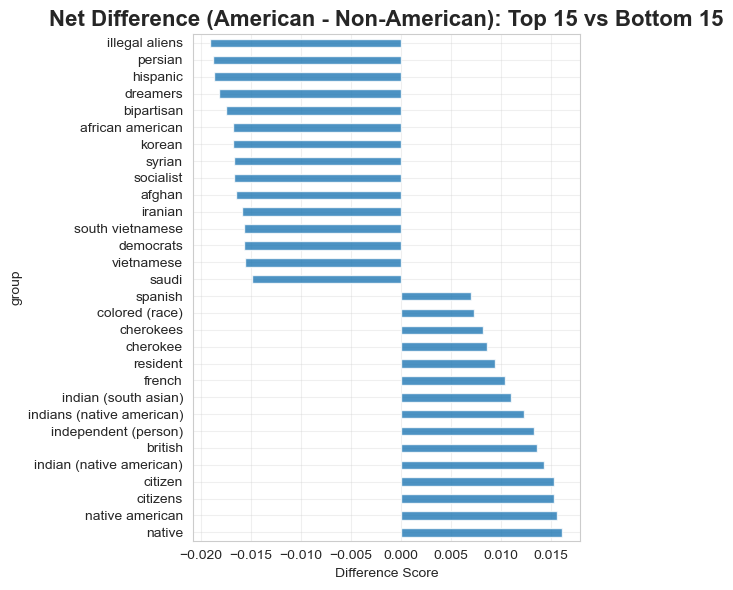

In [140]:
# Net difference plot
fig, ax = plt.subplots(figsize=(6, 6))

diff_df = results_df.set_index('group').sort_values('difference', ascending=False)
diff_df_top_bottom_15 = pd.concat([diff_df.head(15), diff_df.tail(15)])

diff_df_top_bottom_15['difference'].plot(kind='barh', ax=ax, alpha=0.8)

ax.set_title("Net Difference (American - Non-American): Top 15 vs Bottom 15",
             fontsize=16, fontweight='bold')
ax.set_xlabel("Difference Score")
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

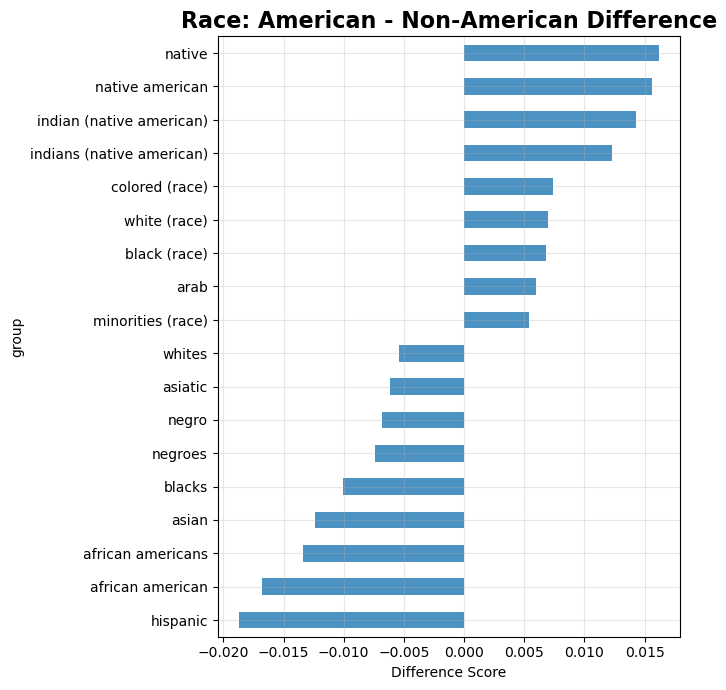

In [813]:
cat = 'race'

# Filter to this category only
df_cat = results_df[results_df['category'] == cat].copy()

# Sort highest → lowest net difference
df_cat_sorted = df_cat.sort_values('difference', ascending=False).set_index('group')

fig, ax = plt.subplots(figsize=(7, 7))

df_cat_sorted['difference'].plot(kind='barh', ax=ax, alpha=0.8)

ax.set_title(
    f"{cat.title()}: American - Non-American Difference",
    fontsize=16, fontweight='bold'
)
ax.set_xlabel("Difference Score")
ax.grid(True, alpha=0.3)

# Put highest at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


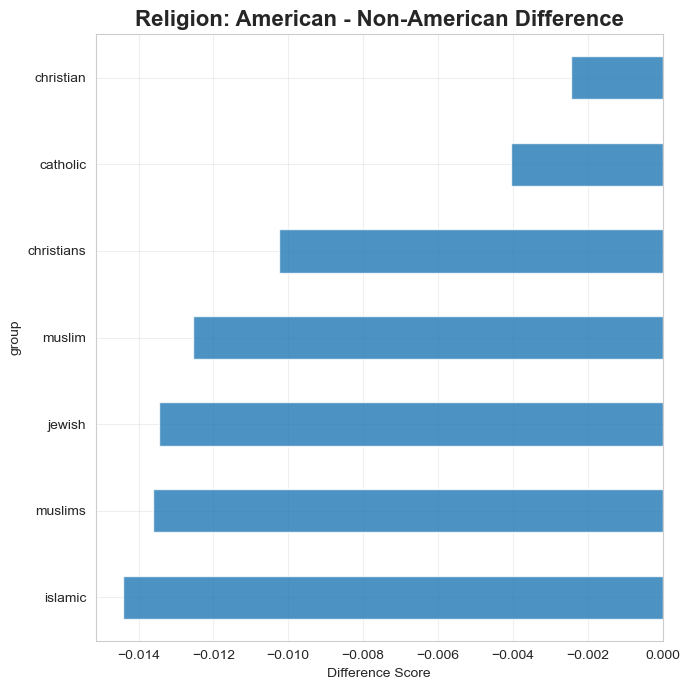

In [835]:
cat = 'religion'

# Filter to this category only
df_cat = results_df[results_df['category'] == cat].copy()

# Sort highest → lowest net difference
df_cat_sorted = df_cat.sort_values('difference', ascending=False).set_index('group')

fig, ax = plt.subplots(figsize=(7, 7))

df_cat_sorted['difference'].plot(kind='barh', ax=ax, alpha=0.8)

ax.set_title(
    f"{cat.title()}: American - Non-American Difference",
    fontsize=16, fontweight='bold'
)
ax.set_xlabel("Difference Score")
ax.grid(True, alpha=0.3)

# Put highest at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


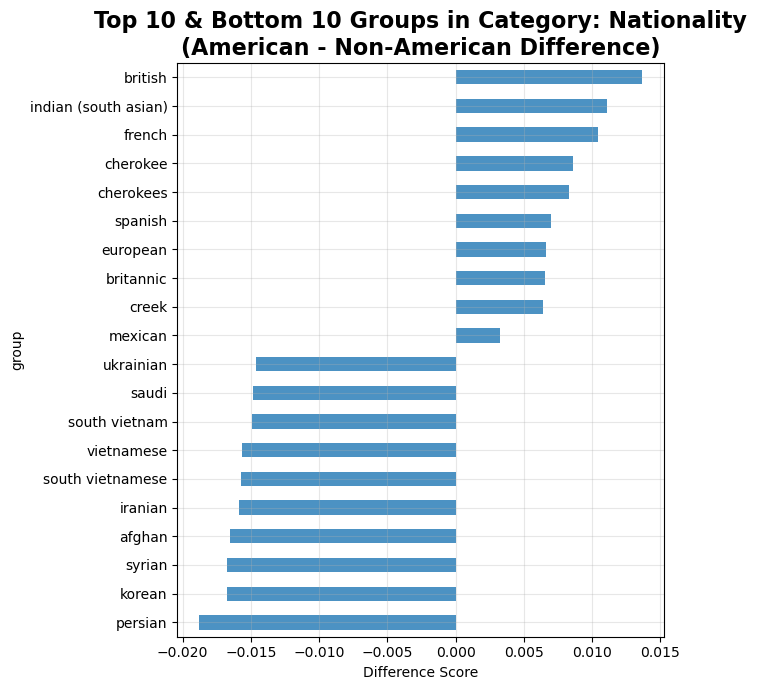

In [815]:
cat = 'nationality'

# Filter to this category only
df_cat = results_df[results_df['category'] == cat].copy()

# Sort highest → lowest net difference
df_cat_sorted = df_cat.sort_values('difference', ascending=False)

# Top 10 and bottom 10
num = 10
top = df_cat_sorted.head(num)
bottom = df_cat_sorted.tail(num)

# Combine
combined = pd.concat([top, bottom]).set_index('group')

fig, ax = plt.subplots(figsize=(7, 7))

combined['difference'].plot(kind='barh', ax=ax, alpha=0.8)

ax.set_title(
    f"Top {num} & Bottom {num} Groups in Category: {cat.title()}\n(American - Non-American Difference)",
    fontsize=16, fontweight='bold'
)
ax.set_xlabel("Difference Score")
ax.grid(True, alpha=0.3)

# Put highest at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


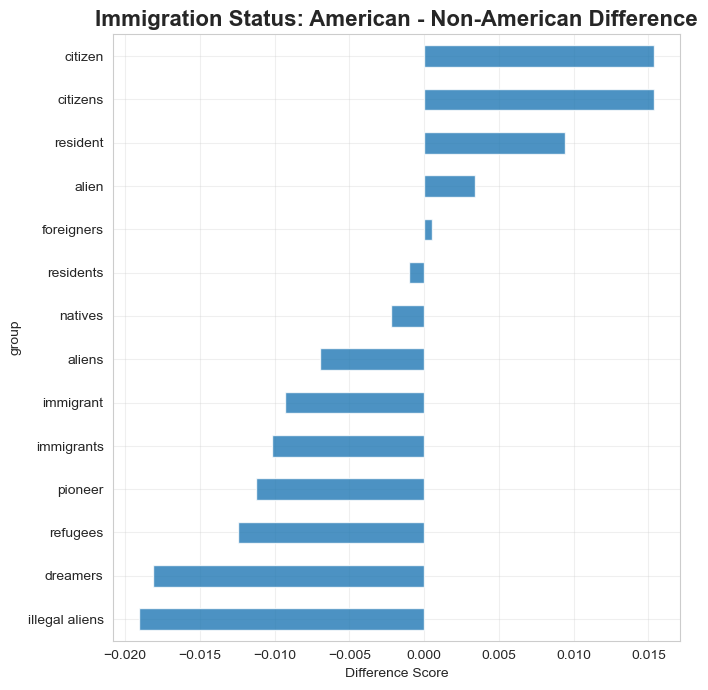

In [838]:
cat = 'immigration_status'

# Filter to this category only
df_cat = results_df[results_df['category'] == cat].copy()

# Sort highest → lowest net difference
df_cat_sorted = df_cat.sort_values('difference', ascending=False).set_index('group')

fig, ax = plt.subplots(figsize=(7, 7))

df_cat_sorted['difference'].plot(kind='barh', ax=ax, alpha=0.8)

ax.set_title(
    f"{cat.replace('_', ' ').title()}: American - Non-American Difference",
    fontsize=16, fontweight='bold'
)
ax.set_xlabel("Difference Score")
ax.grid(True, alpha=0.3)

# Put highest at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


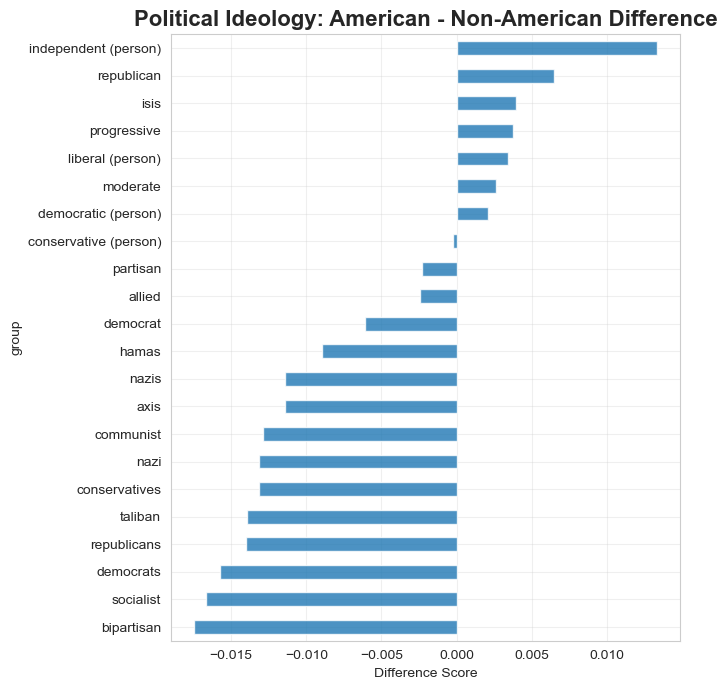

In [839]:
cat = 'political_ideology'

# Filter to this category only
df_cat = results_df[results_df['category'] == cat].copy()

# Sort highest → lowest net difference
df_cat_sorted = df_cat.sort_values('difference', ascending=False).set_index('group')

fig, ax = plt.subplots(figsize=(7, 7))

df_cat_sorted['difference'].plot(kind='barh', ax=ax, alpha=0.8)

ax.set_title(
    f"{cat.replace('_', ' ').title()}: American - Non-American Difference",
    fontsize=16, fontweight='bold'
)
ax.set_xlabel("Difference Score")
ax.grid(True, alpha=0.3)

# Put highest at top
ax.invert_yaxis()

plt.tight_layout()
plt.show()


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/2743117621.py:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=10)


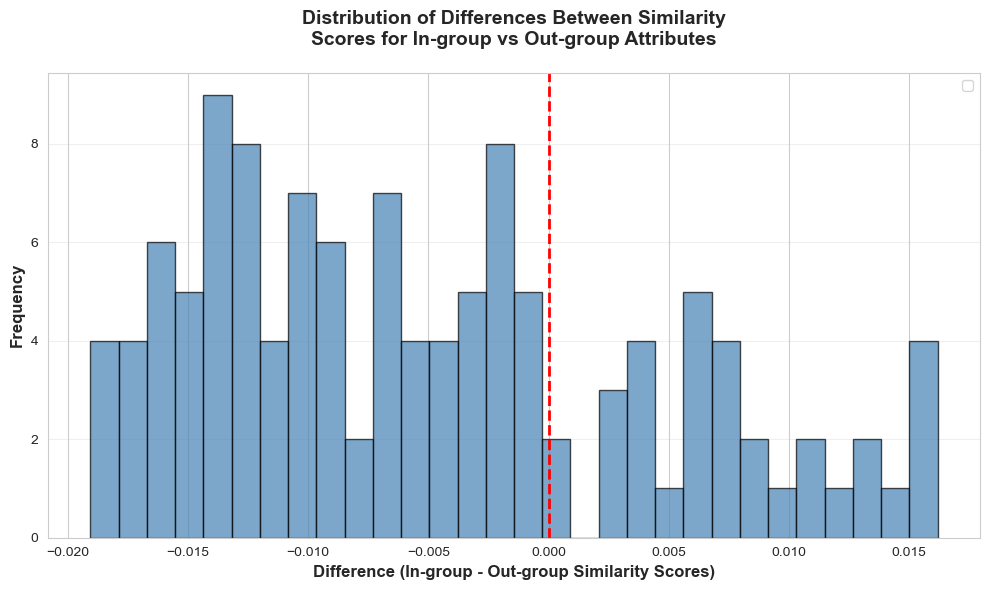

In [148]:
plt.figure(figsize=(10, 6))

# Create histogram
plt.hist(results_df['difference'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)

# Add vertical line at zero
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)

# Labels and title
plt.xlabel('Difference (In-group - Out-group Similarity Scores)', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Distribution of Differences Between Similarity\nScores for In-group vs Out-group Attributes', 
          fontsize=14, fontweight='bold', pad=20)

# Add legend
plt.legend(fontsize=10)

# Add grid for readability
plt.grid(axis='y', alpha=0.3)

# Tight layout
plt.tight_layout()
plt.show()

In [155]:
def analyze_by_decade(df, year_col, text_col, in_group_adj, out_group_adj, demographic_groups):
    """
    Run the bias analysis for each decade.

    Args:
        df: DataFrame containing speeches
        year_col: Column name with year information
        text_col: Column name with speech text
        in_group_adj: List of in-group adjectives
        out_group_adj: List of out-group adjectives
        demographic_groups: Dictionary of demographic groups and their terms
    """
    # Create decade column
    df['decade'] = (df[year_col] // 10) * 10
    
    all_results = []
    
    for decade in sorted(df['decade'].unique()):
        print(f"\nAnalyzing {decade}s...")
        decade_df = df[df['decade'] == decade]
        
        # Get reference embeddings for this decade
        american_emb = get_contextual_embedding(decade_df, in_group_adj, text_col)
        non_american_emb = get_contextual_embedding(decade_df, out_group_adj, text_col)
        
        # Analyze each demographic group
        for category, groups in demographic_groups.items():
            for group in groups:
                group_emb = get_contextual_embedding(decade_df, [group], text_col)
                
                american_sim = cosine_similarity([group_emb], [american_emb])[0][0]
                non_american_sim = cosine_similarity([group_emb], [non_american_emb])[0][0]
                
                all_results.append({
                    'decade': decade,
                    'category': category,
                    'group': group,
                    'american_similarity': american_sim,
                    'non_american_similarity': non_american_sim,
                    'difference': american_sim - non_american_sim,
                    'n_speeches': len(decade_df)
                })
    
    return pd.DataFrame(all_results)

# Run analysis
results_by_decade_df = analyze_by_decade(
    df=speeches_clean_meaning_w_context,
    year_col='year',
    text_col='transcript_cleaned',
    in_group_adj=in_group_adj_final,
    out_group_adj=out_group_adj_final,
    demographic_groups=filtered_demographic_groups
)


Analyzing 1780s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1790s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1800s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1810s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1820s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1830s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1840s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1850s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1860s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1870s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1880s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1890s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1900s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1910s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1920s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1930s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1940s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1950s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1960s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1970s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1980s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 1990s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 2000s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 2010s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h


Analyzing 2020s...


/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = df[text_column].str.contains(word, case=False, na=False)
/var/folders/7w/t6w_w15x5nb5xfxzxr9z18g80000gn/T/ipykernel_67324/3753302189.py:17: UserWarning: This pattern is interpreted as a regular expression, and h

In [154]:
def count_term_frequency_by_decade(df, text_col, year_col, demographic_groups):
    """
    Counts how often each demographic group term appears in each decade.
    Returns a dataframe with decade, term, category, and count.

    Args:
        df: DataFrame containing speeches
        text_col: Column name with speech text
        year_col: Column name with year information
        demographic_groups: Dictionary of demographic groups and their terms
    """
    # Create decade column
    df['decade'] = (df[year_col] // 10) * 10
    
    results = []
    
    for decade in sorted(df['decade'].unique()):
        print(f"Processing {decade}s...")
        
        # Filter to this decade
        decade_df = df[df['decade'] == decade]
        
        # Join all speeches from this decade
        full_text = " ".join(decade_df[text_col].astype(str).tolist()).lower()
        
        for category, group_list in demographic_groups.items():
            for term in group_list:
                # Escape special characters but preserve the pattern
                term_lower = term.lower()
                escaped = re.escape(term_lower)
                
                # Count occurrences using regex
                count = len(re.findall(escaped, full_text))
                
                results.append({
                    'decade': decade,
                    'category': category,
                    'term': term,
                    'term_count': count,
                    'n_speeches': len(decade_df),
                    'term_count_per_speech': count / len(decade_df) if len(decade_df) > 0 else 0
                })
    
    return pd.DataFrame(results)

freq_by_decade_df = count_term_frequency_by_decade(
    df=speeches_clean_meaning_w_context,
    text_col='transcript_cleaned',
    year_col='year',
    demographic_groups=demographic_groups
)

Processing 1780s...
Processing 1790s...
Processing 1800s...
Processing 1810s...
Processing 1820s...
Processing 1830s...
Processing 1840s...
Processing 1850s...
Processing 1860s...
Processing 1870s...
Processing 1880s...
Processing 1890s...
Processing 1900s...
Processing 1910s...
Processing 1920s...
Processing 1930s...
Processing 1940s...
Processing 1950s...
Processing 1960s...
Processing 1970s...
Processing 1980s...
Processing 1990s...
Processing 2000s...
Processing 2010s...
Processing 2020s...


In [157]:
# Looking at results

results_by_decade_df_grouped = results_by_decade_df.merge(
        freq_by_decade_df[['decade', 'term', 'term_count', 'term_count_per_speech']],
        right_on=['decade', 'term'],
        left_on=['decade', 'group'])[['decade', 'category', 'term', 'difference', 'n_speeches', 'term_count']]

# Limiting based on number of speeches and term count
results_by_decade_df_restricted = results_by_decade_df_grouped[(results_by_decade_df_grouped['n_speeches'] > 10) & (results_by_decade_df_grouped['term_count'] > 10)]
results_by_decade_df_restricted.sort_values('difference', ascending=False).head(10)

,decade,category,term,difference,n_speeches,term_count
2617,1990,nationality,iraqi,0.087958,54,24
2121,1950,nationality,european,0.080352,19,14
254,1800,race,indian (native american),0.075673,29,21
2637,1990,nationality,saudi,0.058639,54,23
2123,1950,nationality,german,0.052870,19,15
1448,1890,political_ideology,democrat,0.051519,40,26
2087,1950,race,native,0.048768,19,18
132,1790,race,indian (native american),0.048253,26,21
2633,1990,nationality,persian,0.044680,54,21
1582,1900,political_ideology,republican,0.044565,31,36


In [889]:
top_15_list = diff_df.head(15).reset_index()['group'].to_list()
bottom_15_list = diff_df.tail(15).reset_index()['group'].to_list()

In [904]:
for t in top_15_list:

    sorted_best = results_by_decade_df_restricted[results_by_decade_df_restricted['term'] == t].sort_values('difference', ascending=False).reset_index()
    if len(sorted_best) > 1:
        best_decade = sorted_best.loc[0, 'decade']
    else:
         best_decade = 'Not enough data'
    sorted_worst = results_by_decade_df_restricted[results_by_decade_df_restricted['term'] == t].sort_values('difference').reset_index()
    if len(sorted_worst) > 1:
        worst_decade = sorted_worst.loc[0, 'decade']
    else:
        worst_decade = 'Not enough data'
    
    print(t)
    print('-------')
    print(f"Best Decade: {best_decade}")
    print(f"Worst Decade: {worst_decade}\n")

native
-------
Best Decade: 1950
Worst Decade: 1990

native american
-------
Best Decade: 1790
Worst Decade: 1920

citizens
-------
Best Decade: 1960
Worst Decade: 1990

citizen
-------
Best Decade: 1950
Worst Decade: 1990

indian (native american)
-------
Best Decade: 1800
Worst Decade: 1870

british
-------
Best Decade: 1920
Worst Decade: 1800

independent (person)
-------
Best Decade: 1960
Worst Decade: 1840

indians (native american)
-------
Best Decade: 1790
Worst Decade: 1870

indian (south asian)
-------
Best Decade: Not enough data
Worst Decade: Not enough data

french
-------
Best Decade: 1920
Worst Decade: 1810

resident
-------
Best Decade: 1900
Worst Decade: 1910

cherokee
-------
Best Decade: 1790
Worst Decade: 1840

cherokees
-------
Best Decade: 1790
Worst Decade: 1840

colored (race)
-------
Best Decade: 1860
Worst Decade: 1870

spanish
-------
Best Decade: 1810
Worst Decade: 1890



In [903]:
for b in bottom_15_list:

    sorted_best = results_by_decade_df_restricted[results_by_decade_df_restricted['term'] == b].sort_values('difference', ascending=False).reset_index()
    if len(sorted_best) > 1:
        best_decade = sorted_best.loc[0, 'decade']
    else:
         best_decade = 'Not enough data'
    sorted_worst = results_by_decade_df_restricted[results_by_decade_df_restricted['term'] == b].sort_values('difference').reset_index()
    if len(sorted_worst) > 1:
        worst_decade = sorted_worst.loc[0, 'decade']
    else:
        worst_decade = 'Not enough data'
    
    print(b)
    print('-------')
    print(f"Best Decade: {best_decade}")
    print(f"Worst Decade: {worst_decade}\n")

south vietnam
-------
Best Decade: 1970
Worst Decade: 1960

vietnamese
-------
Best Decade: 1970
Worst Decade: 1960

democrats
-------
Best Decade: 2000
Worst Decade: 1990

south vietnamese
-------
Best Decade: 1970
Worst Decade: 1960

iranian
-------
Best Decade: 2020
Worst Decade: 2000

afghan
-------
Best Decade: 1980
Worst Decade: 2020

socialist
-------
Best Decade: Not enough data
Worst Decade: Not enough data

syrian
-------
Best Decade: Not enough data
Worst Decade: Not enough data

korean
-------
Best Decade: 1980
Worst Decade: 1960

african american
-------
Best Decade: 2010
Worst Decade: 1990

bipartisan
-------
Best Decade: 2000
Worst Decade: 1990

dreamers
-------
Best Decade: Not enough data
Worst Decade: Not enough data

hispanic
-------
Best Decade: 2010
Worst Decade: 1980

persian
-------
Best Decade: 1990
Worst Decade: 1980

illegal aliens
-------
Best Decade: Not enough data
Worst Decade: Not enough data

